In [79]:
import pandas as pd
#import matplotlib.pyplot as plt
from datetime import datetime

In [80]:
request_data = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/sample-hourly-request-rate.csv')

#Medium
Refer to https://rahulaga.medium.com/time-series-forecasting-with-facebook-prophet-f0468ff6fa3b

# Understanding the data
See above article

In [81]:
#convert type to datetime
request_data['Time'] = pd.to_datetime(request_data["Time"])

#For Prophet the time columns must be called ds and value as y
#note creating copy as going to set orginal Time as index
request_data['ds'] = request_data['Time']
request_data.rename(columns={'Point': 'y'}, inplace=True)

#set index as time for the series
request_data = request_data.set_index('Time')

In [82]:
request_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2021-04-08 19:00:00 to 2021-05-06 18:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       672 non-null    float64       
 1   ds      672 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 KB


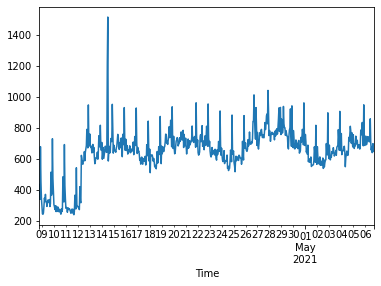

In [83]:
# plot everything
request_data['y'].plot()

#Load observed future data
Loading next set of 7day data (7*24 rows)
Comparing this with forecast.

In [84]:
request_data_future = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/test-hourly-request-rate.csv')
print(request_data_future.shape)
request_data_future.tail()

(168, 2)


,Time,Point
163,5/13/21 14:00,856.887222
164,5/13/21 15:00,717.899167
165,5/13/21 16:00,709.526389
166,5/13/21 17:00,737.645278
167,5/13/21 18:00,855.658056


In [85]:
request_data_future['ds'] = request_data_future['Time']
#convert type to datetime
request_data_future['ds'] = pd.to_datetime(request_data_future['ds'])

request_data_future = request_data_future.set_index('Time')
request_data_future.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 5/6/21 19:00 to 5/13/21 18:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Point   168 non-null    float64       
 1   ds      168 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.9+ KB


In [86]:
#compare forecast with 7day future (used below)
def compare_future(forecast, title):
  forecast_tail = forecast.tail(7*24)
  fig, ax = plt.subplots()
  fig.set_size_inches(15,4)
  ax.fill_between(forecast_tail.ds, forecast_tail['yhat_lower'], forecast_tail['yhat_upper'], alpha=0.2)
  line1 = plt.plot(forecast_tail.ds, forecast_tail['yhat'], c='blue', label='forecast')
  line2 = plt.plot(request_data_future.ds, request_data_future['Point'], c='red', label='observed')

  lines = line1+line2
  labels = [l.get_label() for l in lines]
  ax.legend(lines, labels, loc=0)

  plt.title(title)

# Greykite
https://rahulaga.medium.com/time-series-forecasting-with-greykite-f387f1ee6b89


In [87]:
!pip install greykite

In [88]:
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum

In [89]:
gk_metadata = MetadataParam(
    time_col="ds",     # time column 
    value_col="y",     # value 
    freq="H"           # hourly data
)
gk_forecaster = Forecaster()  # creates forecasts and stores the result
gk_result = gk_forecaster.run_forecast_config(
     df=request_data,
     config=ForecastConfig(
         # uses the SILVERKITE model template parameters
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=7*24,  # 1 week forecast
         coverage=0.95,         # 95% prediction intervals
         metadata_param=gk_metadata
     )
 )

Fitting 1 folds for each of 1 candidates, totalling 1 fits


/usr/local/lib/python3.7/dist-packages/greykite/sklearn/cross_validation.py:194: UserWarning:

There is only one CV split

/usr/local/lib/python3.7/dist-packages/greykite/algo/uncertainty/conditional/conf_interval.py:221: UserWarning:

No slice had sufficient sample size. We fall back to the overall distribution.

/usr/local/lib/python3.7/dist-packages/greykite/algo/uncertainty/conditional/conf_interval.py:221: UserWarning:

No slice had sufficient sample size. We fall back to the overall distribution.

/usr/local/lib/python3.7/dist-packages/greykite/algo/uncertainty/conditional/conf_interval.py:221: UserWarning:

No slice had sufficient sample size. We fall back to the overall distribution.

/usr/local/lib/python3.7/dist-packages/greykite/sklearn/transform/null_transformer.py:178: RuntimeWarning:

Input data has many null values. Missing 20.00% of one input.



In [90]:
# train test split by grey kite
gk_forecast = gk_result.forecast
gk_forecast.plot()

Figure({
    'data': [{'legendgroup': 'interval',
              'line': {'color': 'rgba(0, 90, 181, 0.5)', 'width': 0.0},
              'mode': 'lines',
              'name': 'Lower Bound',
              'type': 'scatter',
              'uid': 'c0a81c5d-1269-4af7-ade3-a40860f85a1a',
              'x': array([datetime.datetime(2021, 4, 8, 19, 0),
                          datetime.datetime(2021, 4, 8, 20, 0),
                          datetime.datetime(2021, 4, 8, 21, 0), ...,
                          datetime.datetime(2021, 5, 13, 16, 0),
                          datetime.datetime(2021, 5, 13, 17, 0),
                          datetime.datetime(2021, 5, 13, 18, 0)], dtype=object),
              'y': array([453.40719918, 409.07498413, 577.49055646, ..., 447.22311872,
                          462.93014692, 513.95207129])},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 90, 181, 0.15)',
              'legendgroup': 'interval',
              'line': {'color': 'rgba

In [91]:
gk_forecast_df = gk_forecast.df.rename(columns={"forecast":"yhat","forecast_lower":"yhat_lower","forecast_upper":"yhat_upper"})

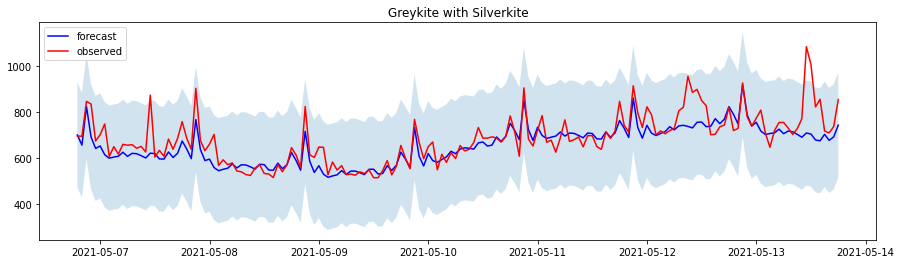

In [92]:
compare_future(gk_forecast_df, 'Greykite with Silverkite')

# Compare FB, silverkite, sarima
Predictions saved from https://rahulaga.medium.com/time-series-forecasting-with-facebook-prophet-f0468ff6fa3b

In [101]:
predictions_sarima = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/predictions-sarima.csv')
predictions_sarima['ds']=pd.to_datetime(predictions_sarima['ds'])
predictions_sarima.info()
#predictions_sarima.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   sarima  168 non-null    float64       
 1   ds      168 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB


In [102]:
predictions_fb_multi = pd.read_csv('https://raw.githubusercontent.com/rahulaga/ml-for-business/main/timeseries/predictions-fb-multi.csv')
predictions_fb_multi['ds']=pd.to_datetime(predictions_fb_multi['ds'])
predictions_fb_multi.info()
predictions_fb_multi = predictions_fb_multi.tail(7*24)
#predictions_fb_multi.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          840 non-null    datetime64[ns]
 1   trend                       840 non-null    float64       
 2   yhat_lower                  840 non-null    float64       
 3   yhat_upper                  840 non-null    float64       
 4   trend_lower                 840 non-null    float64       
 5   trend_upper                 840 non-null    float64       
 6   daily                       840 non-null    float64       
 7   daily_lower                 840 non-null    float64       
 8   daily_upper                 840 non-null    float64       
 9   multiplicative_terms        840 non-null    float64       
 10  multiplicative_terms_lower  840 non-null    float64       
 11  multiplicative_terms_upper  840 non-null    float64       

In [100]:
gk_predictions = gk_forecast_df.tail(7*24)
gk_predictions.tail(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 672 to 839
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ds          168 non-null    datetime64[ns]
 1   actual      0 non-null      float64       
 2   yhat        168 non-null    float64       
 3   yhat_lower  168 non-null    float64       
 4   yhat_upper  168 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 6.7 KB


Text(0.5, 1.0, 'Compare predictions')

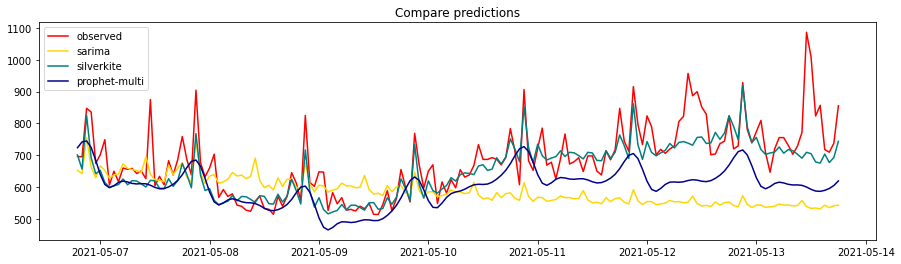

In [106]:
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
line1 = plt.plot(request_data_future.ds, request_data_future['Point'], c='red', label='observed')
line2 = plt.plot(predictions_sarima.ds, predictions_sarima['sarima'], c='gold', label='sarima')
line3 = plt.plot(gk_predictions.ds, gk_predictions['yhat'], c='teal', label='silverkite')
line4 = plt.plot(predictions_fb_multi.ds, predictions_fb_multi['yhat'], c='darkblue', label='prophet-multi')


lines = line1+line2+line3+line4
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc=0)
plt.title("Compare predictions")